# Confidence intervals for stochastic arithmetic

Accompanying Material: Executable Jupyter Notebook implementing the paper's proposed confidence intervals

This notebook allows to easily reproduce the results of our paper. Moreover it provides Python implementations for computing confidence intervals on the number of *significant* and *contributing* bits as defined in the paper. 

## User defined inputs

First, the input data must be provided by the user. It is a set of samples of the stochastic variable of interest. 

In [1]:
# By default, only 40 samples of Cramer x[0] variable are used. 
# The full set of 10 000 samples can read by toggling the following boolean variable: 
USE_ALL_SAMPLES=False

if USE_ALL_SAMPLES:
    input_data = open('cramer-x0-10000.txt').read()
else:
    input_data = '''
    1.9999999918398770e+00
    1.9999999940952646e+00
    2.0000000011503523e+00
    1.9999999933784054e+00
    1.9999999948951419e+00
    1.9999999968609947e+00
    2.0000000069023227e+00
    2.0000000038111487e+00
    2.0000000036907464e+00
    1.9999999982520564e+00
    1.9999999906289869e+00
    2.0000000081909284e+00
    1.9999999966543776e+00
    1.9999999959263037e+00
    2.0000000001025922e+00
    1.9999999930921388e+00
    1.9999999932441190e+00
    2.0000000031827048e+00
    1.9999999942054751e+00
    2.0000000050547291e+00
    1.9999999898975742e+00
    2.0000000032795717e+00
    2.0000000020193753e+00
    1.9999999971086673e+00
    1.9999999990894570e+00
    2.0000000002885794e+00
    1.9999999992440545e+00
    1.9999999998419928e+00
    1.9999999956601755e+00
    1.9999999915987137e+00
    2.0000000077894300e+00
    1.9999999991071007e+00
    1.9999999992969841e+00
    2.0000000096555106e+00
    1.9999999976827307e+00
    1.9999999963294071e+00
    1.9999999992822308e+00
    1.9999999951722092e+00
    2.0000000049780846e+00
    1.9999999999443261e+00
    '''

The user must also choose,

* a reference value. If one wants to use the sample mean as reference value, reference can be set to the string value `'mean'`
* if errors are relative or absolute
* the confidence alpha to use for the intervals
* the probability for acertaining significance (.99 means that the k-th bit is signicant 99 times out of 100) 
* the probability for acertaining contribution (.01 means that the k-th bit contributes to the result 1 time out of 100)

In [2]:
reference = 'mean'
relative = True
alpha = .95
significant_p = .99
contributing_p = .51

## Python preamble

In [3]:
%matplotlib inline
import math
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('bmh')

The input samples are parsed. And the reference value printed.

In [4]:
samples = np.fromstring(input_data, sep=' ', dtype='float64')
if reference == 'mean':
    reference = samples.mean()

print("The reference is {}".format(reference))

The reference is 1.9999999988106212


We define an `error` function which computes the error residual. We define the $Z$ error distribution and compute its moments.

In [5]:
if relative:
    error = lambda x: x/reference - 1 
    eref = 1
else:
    error = lambda x: x - reference 
    eref = math.floor(math.log2(abs(reference)))+1
    
Z = np.array([error(s) for s in samples])

print("Z.muhat = {:e} Z.sigmahat = {:e}".format(Z.mean(), Z.std()))

Z.muhat = -6.383782e-17 Z.sigmahat = 2.486136e-09


## Test Normality

Before going further, we test the normality of `Z`. Depending on the result we will apply the analysis for the *Normal* or *General* case.

In [6]:
def test_normality(Z, show_plots=True):
    """ Test the normality of Z distribution. 
        When `show_plots` is true, an histogram and QQ-plot are shown.
       
        returns a pair with a boolean indicating normality and the test
        statistics.
    """

    if show_plots:
        plt.figure(figsize=(6.5,3))
        plt.rc('xtick', labelsize=9)
        plt.rc('ytick', labelsize=9)

        plt.subplot(1, 2, 1)
        plt.hist(Z,bins='auto',normed=True)
        xt = plt.xticks()[0]  
        lnspc = np.linspace(min(xt), max(xt), 100)
        mu, std = stats.norm.fit(Z)
        plt.plot(lnspc, stats.norm.pdf(lnspc, mu, std), '--', linewidth=2, alpha=.7)
        plt.subplot(1, 2, 2)
        stats.probplot(Z, dist="norm", plot=plt)
        plt.tight_layout()        
        plt.savefig('qqplot.pdf')
        plt.show()
    normaltest = stats.shapiro(Z)
    return normaltest[1] < 0.1, normaltest

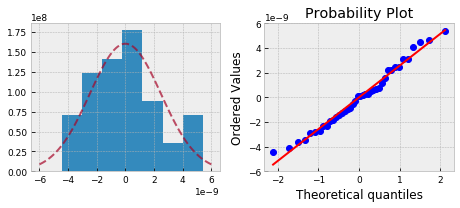

The distribution passes the Shapiro Wilk normality test
W = 0.9774773120880127 p = 0.5966167449951172


In [7]:
normal, test_statistics = test_normality(Z)

if normal:
    print("Normality rejected")
else:
    print("The distribution passes the Shapiro Wilk normality test")

print("W = {} p = {}".format(*test_statistics))

## Empirical Frequencies

We define the two criteria for significance and contribution of the k-th bit.

We count for each $k \in [1:52]$ the number of samples in $Z$ satisfying each criteria.

In [8]:
def significant(z, k):
    """ Returns true when the error is less than the magnitude of the k-th bit"""
    return abs(z) <= 2**(-k+(eref-1))

def contributing(z, k):
    """ Returns true when the k-th bit is zero"""
    return math.floor(abs(z)*2**(k-(eref-1))) % 2 == 0

def count_success(Z, cond):
    """ Return the number of samples in Z that satisfy predicate cond."""
    return sum([cond(z) for z in Z])

# Count the number of samples where the k-th bit is significant or contributing
kth_significant  = np.array([count_success(Z, lambda z: significant(z, k)) for k in range(53)])
kth_contributing = np.array([count_success(Z, lambda z: contributing(z, k)) for k in range(53)])
print("kth-significant:\n", kth_significant)
print("kth-contributing:\n", kth_contributing)

kth-significant:
 [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 34 20 12  6  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
kth-contributing:
 [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 34 26 25 20 19 24 20 13 26 22 23 20 23 22 19 22 24 23 20 27 22 14
 21 24 17]


We define a function to plot the confidence intervals that will be computed in the following sections against the empirical distributions.

In [9]:
def confidence_plot(empirical_freq, ci_probability, title='', minx=0):
    """ Plots both the empirical frequency and the CI lower bound."""
    if minx > 0:
        empirical_freq = empirical_freq[minx:]
        ci_probability = ci_probability[minx:]
        
    x = np.arange(minx, 53)
    plt.figure(figsize=(4.3,3))
    plt.plot(x, empirical_freq, '-')
    plt.plot(x, ci_probability, '--')
    plt.ylabel('probability')
    plt.xlabel('k')
    plt.title(title)
    plt.legend(['empirical', 'CI lower bound'])
    plt.savefig('confidenc-plot.pdf')

## Normal Case

### Significant Bits

In [10]:
def sigma_upper_bound(Z, alpha):
    """ Returns an upper bound on sigma assuming Z is normal (uses Chi-2 CI) """
    return math.sqrt((Z.size-1)*Z.std()**2 / stats.chi2.interval(alpha, Z.size-1)[0])

print("sigmahat = {} sigma upper bound (CI Chi2) = {}".format(Z.std(), sigma_upper_bound(Z, alpha)))

sigmahat = 2.4861359693682457e-09 sigma upper bound (CI Chi2) = 3.1922868195572187e-09


initial_significant_bits = 28.22276257380348 correction = 1.3650369913240126
significant_bits = 26.857725582479468 with p = 0.99 and alpha = 0.95


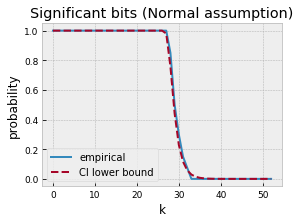

In [11]:
def significant_normal_probability(Z, alpha, k, eref):
    """ Computes the probability lower-bound of 
        the k-th bit being significant in the normal case """
    return (2*stats.norm.cdf(2**(-k+(eref-1))/sigma_upper_bound(Z, alpha))-1)

def significant_normal(Z, alpha, p, eref):
    """ Computes the lower bound on the significant bits in the normal case """
    sigma_ub = sigma_upper_bound(Z, alpha)
    if sigma_ub > 0:
        sg_bits = -math.log2(sigma_ub)+(eref-1)
    else:
        sg_bits = 53+(eref-1)
    sg_correction = math.log2(stats.norm.ppf((p+1)/2))
    sg_lb = sg_bits-sg_correction
    return (sg_lb, sg_bits, sg_correction)
    
sg_lb, sg_bits, sg_correction = significant_normal(Z, alpha, significant_p, eref)
print("initial_significant_bits = {} correction = {}".format(sg_bits, sg_correction))
print("significant_bits = {} with p = {} and alpha = {}".format(sg_lb, significant_p, alpha))

confidence_plot(kth_significant/Z.size, 
                [significant_normal_probability(Z, alpha, k, eref) for k in range(53)], 
                "Significant bits (Normal assumption)")

### Contributing Bits

contributing correction = 4.318108125038564
contributings_bits = 32.54087069884204 with p = 0.51 and alpha = 0.95


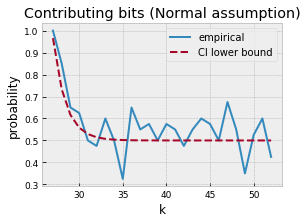

In [12]:
def contributing_normal_probability(Z, alpha, k, eref):
    """ Computes an approximation of the probability of 
        the k-th bit contributing in the normal case """
    sigma_ub = sigma_upper_bound(Z, alpha)
    if sigma_ub > 0:
        return (2**(-k+(eref-1))/(2*sigma_ub*math.sqrt(2*math.pi)))+.5 #- (2**(-k))**3*(4*math.exp(-3/2.)+1)/(12*sigma_ub**3*math.sqrt(2*math.pi))
    else:
        return 1

def contributing_normal(Z, alpha, p, eref):
    """ Computes the lower bound on the contributing bits in the normal case """
    if p > .7: 
        assert False, ("The contributing bits approximation formula is not valid for p > 0.7")
    
    sigma_ub = sigma_upper_bound(Z, alpha)
    if sigma_ub > 0:
        sg_bits = -math.log2(sigma_ub)+(eref-1)
    else:
        sg_bits = 53+(eref-1)
    cb_correction = -math.log2(p-.5)-math.log2(2*math.sqrt(2*math.pi))
    cb_lb =  sg_bits + cb_correction
    return (cb_lb, sg_bits, cb_correction)

cb_lb, sg_bits, cb_correction = contributing_normal(Z, alpha, contributing_p, eref)

print("contributing correction = {}".format(cb_correction))
print("contributings_bits = {} with p = {} and alpha = {}".format(cb_lb, contributing_p, alpha))

confidence_plot(kth_contributing/Z.size, 
                [contributing_normal_probability(Z, alpha, k, eref) for k in range(53)], 
                "Contributing bits (Normal assumption)", minx=math.ceil(max(sg_bits-2,0)))

In [13]:
def format_with_precision(x, s, c, error, relative = False, reference = None):
    """ Returns a representation of x with confidence bounds 
            x: the sample to print
            s: number of significant bits
            c: number of contributing bits
            error: error function
            relative: True when relative please provide a reference value
    """
    interval = 2**(-s)

    if relative:
        assert reference != None, "relative mode requires a reference value"
        interval *= reference 
        
    if abs(error(x)) >= 2**(-s):
        warning = "outlier"
    else:
        warning = ""
    
    return "{0: <8} {1:.{2}} ± {3:.{2}}".format(warning, x,  math.ceil(c*math.log(2)/math.log(10)), interval)    

for i in range(3):
    print("x[{}]    = {}".format(i, format_with_precision(samples[i], sg_lb, cb_lb, error, relative, reference)))
    
print("mean(x) = {}".format(format_with_precision(samples.mean(), sg_lb, cb_lb, error, relative, reference))) 

x[0]    =          1.999999992 ± 1.644557186e-08
x[1]    =          1.999999994 ± 1.644557186e-08
x[2]    =          2.000000001 ± 1.644557186e-08
mean(x) =          1.999999999 ± 1.644557186e-08


## General Case

In [14]:
def bernoulli_lower_bound_probability(success, total, alpha):
    """ Returns the probability lower bound given the number of success and total number of
        Bernoulli trials 
    """
    return (success+2)/(total+4)-stats.norm.ppf(alpha)*math.sqrt((success+2)*(total-success+2)/(total+4)**3)

def all_success_k(success_tab):
    """ Returns the highest k for which the sample never fails """
    return next(i for i,ns in enumerate(success_tab) if ns != Z.size) - 1

def bernoulli_kth_probability(success_tab, k, total, alpha):
    """ Returns the probability lower bound given number of success for a given k"""
    as_k = all_success_k(success_tab)
    
    # Special case for k-th with only successes 
    if k <= as_k:
        return 1+math.log(1-alpha)/total
    else:
        return bernoulli_lower_bound_probability(success_tab[k], total, alpha)
    
def do_bernoulli_analysis(success_tab, total, alpha, name):
    """ Returns probability confidence interval and show confidence plots for 
        a given sucess_tab 
    """
    as_k = all_success_k(success_tab)
    print("{} bits are {} (with no failures in the sample data) with p = {} and alpha = {}".format(
            as_k,
            name.lower(),
            bernoulli_kth_probability(success_tab, as_k, total, alpha), 
            alpha))
    
    confidence_plot(success_tab/total, 
                [bernoulli_kth_probability(success_tab, k, total, alpha) for k in range(53)], 
                "{} bits (Bernoulli)".format(name))

### Significant Bits

27 bits are significant (with no failures in the sample data) with p = 0.9251066931611502 and alpha = 0.95


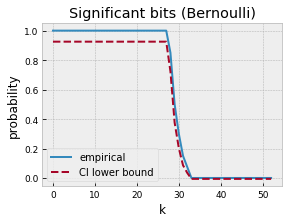

In [15]:
do_bernoulli_analysis(kth_significant, Z.size, alpha, "Significant")

### Contributing Bits

27 bits are contributing (with no failures in the sample data) with p = 0.9251066931611502 and alpha = 0.95


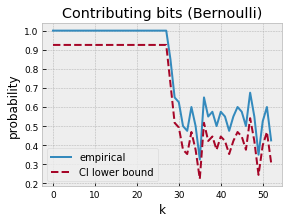

In [16]:
do_bernoulli_analysis(kth_contributing, Z.size, alpha, "Contributing")